In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras import Sequential, Input
from keras.layers import Flatten, Dense

import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts

In [2]:
df = pd.read_csv(r"C:\Users\apico\OneDrive\Escritorio\DEEP LEARNING\PRACTICAS\BBDD\Customer Churn\customer_churn_dataset-training-master.csv")
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
df.shape

(440833, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


### Limpieza y transformación de datos

In [5]:
# Eliminamos columnas no representativas

df = df.drop(['CustomerID'], axis =1)

In [6]:
# Buscamos valores nulos
df.isna().sum()

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [7]:
df = df.dropna()

In [8]:
# Buscamos negativos
columnas = ['Age','Tenure','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction', 'Churn']
negativos = (df[columnas] < 0).any()
negativos

Age                 False
Tenure              False
Usage Frequency     False
Support Calls       False
Payment Delay       False
Total Spend         False
Last Interaction    False
Churn               False
dtype: bool

In [9]:
# Buscamos valores 0 en todas las columnas
columnas = ['Age','Tenure','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction', 'Churn']
valores_0 = (df[columnas] == 0).any()
valores_0
# Los ceros en 'Support Calls', 'Payment Delay' y 'Churn' son totalmente válidos

Age                 False
Tenure              False
Usage Frequency     False
Support Calls        True
Payment Delay        True
Total Spend         False
Last Interaction    False
Churn                True
dtype: bool

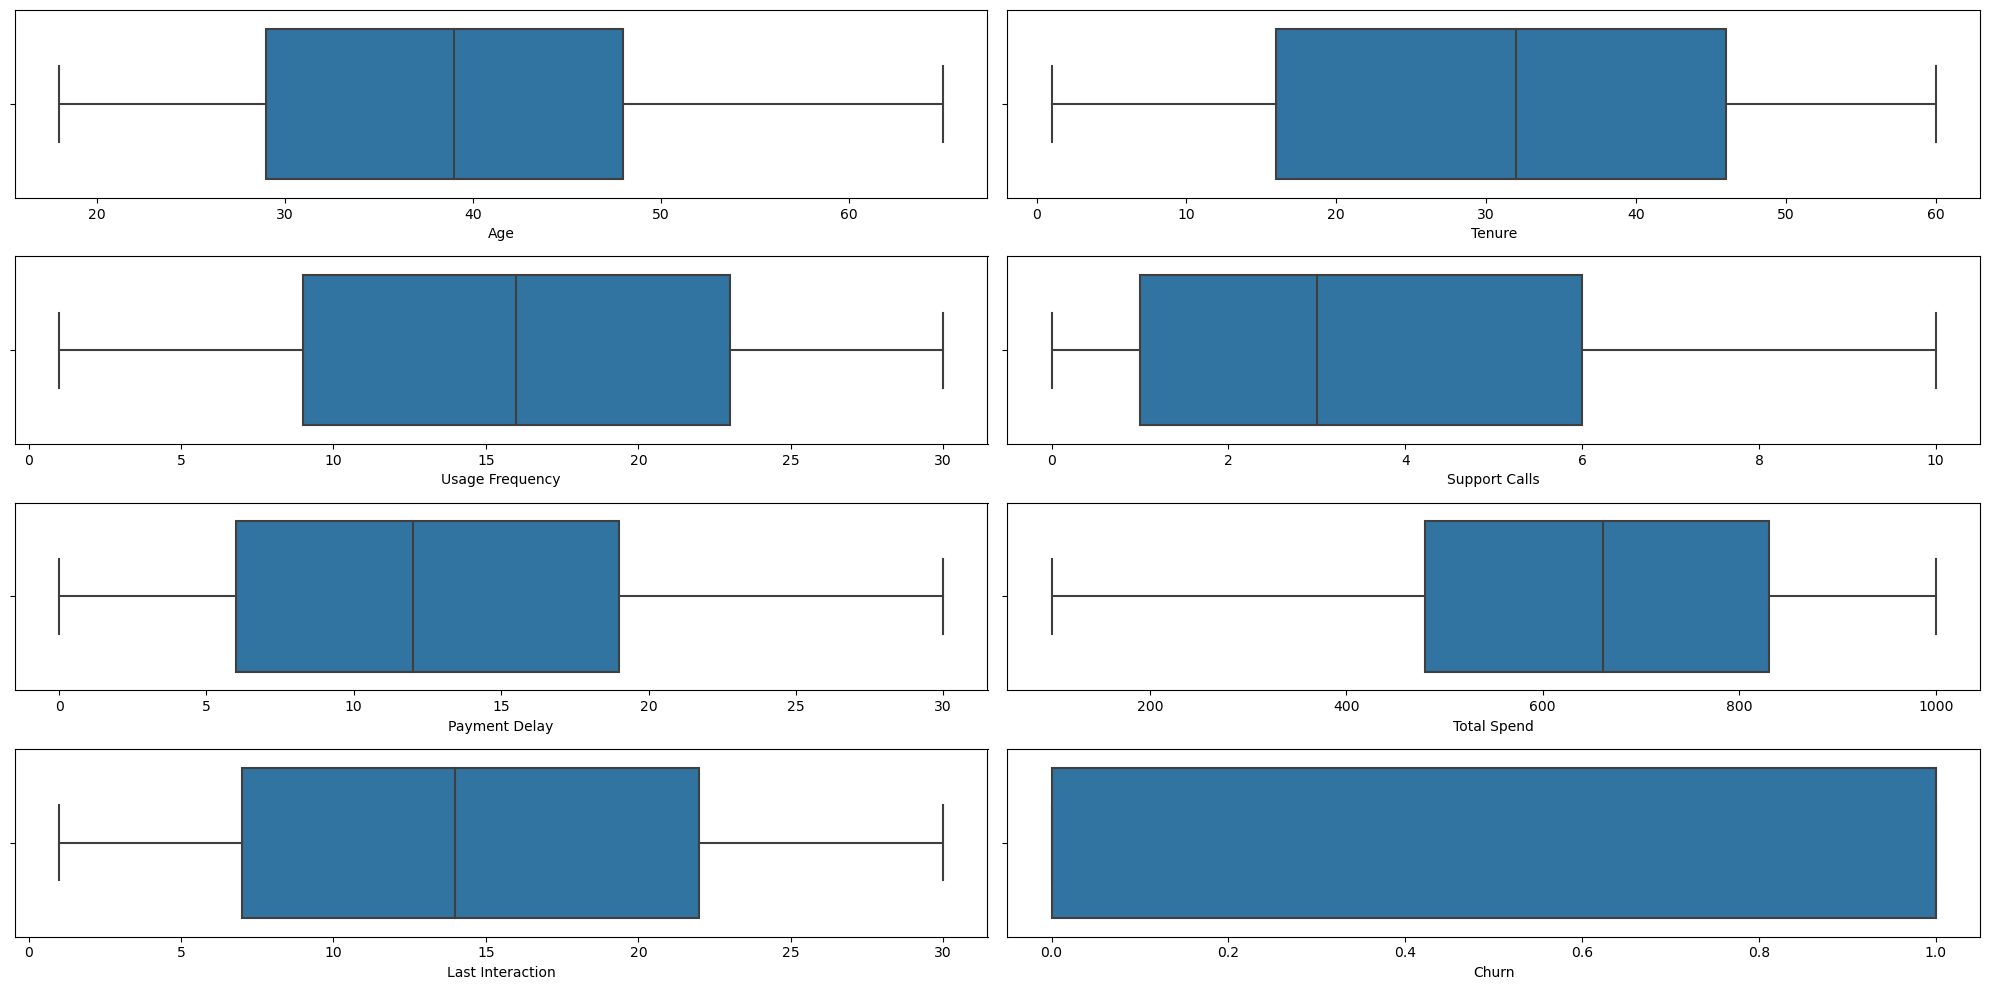

In [10]:
# Visualización de datos en busca de outliers o erroneos

num_vars = ['Age','Tenure','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction', 'Churn']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df, ax=axs[i])

fig.tight_layout()

plt.show()

# No hay valores atípicos

In [11]:
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [12]:
df['Contract Length'].unique()

array(['Annual', 'Monthly', 'Quarterly'], dtype=object)

In [13]:
df['Subscription Type'].unique()

array(['Standard', 'Basic', 'Premium'], dtype=object)

In [ ]:
# Aplicamos get dummies para que todas las columnas valgan lo mismo 


# 'Gender'

df = pd.get_dummies(df, columns=['Gender'])
df.rename(columns = {'Gender_1': 'Female', 'Gender_2': 'Male'}, inplace=True)
df.columns = df.columns.str.replace('Gender_', '')

# 'Subscription Type'

df = pd.get_dummies(df, columns=['Subscription Type'])
df.rename(columns = {'Subscription Type_1': 'Standard', 
                     'Subscription Type_2': 'Basic',
                     'Subscription Type_3': 'Premium'}, inplace=True)
df.columns = df.columns.str.replace('Subscription Type_', '')


# 'Contract Length'

df = pd.get_dummies(df, columns=['Contract Length'])
df.rename(columns = {'Contract Length_1': 'Annual', 
                     'Contract Length_2': 'Monthly',
                     'Contract Length_3': 'Quarterly'}, inplace=True)
df.columns = df.columns.str.replace('Contract Length_', '')


df.head()

### Separación e inspección de los datos 

In [15]:
X = df.drop('Churn', axis=1)

y = df.Churn

In [16]:
# Normalización

X[X.columns] = StandardScaler().fit_transform(X)
X.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction
0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052
1,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584
2,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575
3,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018
4,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043


In [17]:
# Separacion en paquetes de entrenamiento y testeo

X_train, X_test, y_train, y_test = tts(X, y)

In [18]:
# Contamos elementos que componen las datos de prueba y validación

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((330624, 7), (110208, 7), (330624,), (110208,))

### Modelo

In [19]:
model = Sequential()

model.add(Dense(64,                # Dense(64 neuronas)   
                activation='relu',  # Funcion de activación, relu = unidad de rectificado lineal
                input_shape=[X_train.shape[1]])) # las columnas del dataFrame, 9 en este caso

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='softmax'))

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [22]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
10332/10332 [==============================] - 8s 769us/step - loss: 0.1314 - accuracy: 0.5669
Epoch 2/10
10332/10332 [==============================] - 8s 764us/step - loss: 0.1108 - accuracy: 0.5669
Epoch 3/10
10332/10332 [==============================] - 8s 764us/step - loss: 0.1066 - accuracy: 0.5669
Epoch 4/10
10332/10332 [==============================] - 8s 763us/step - loss: 0.1041 - accuracy: 0.5669
Epoch 5/10
10332/10332 [==============================] - 8s 766us/step - loss: 0.1023 - accuracy: 0.5669
Epoch 6/10
10332/10332 [==============================] - 8s 769us/step - loss: 0.1014 - accuracy: 0.5669
Epoch 7/10
10332/10332 [==============================] - 8s 761us/step - loss: 0.1009 - accuracy: 0.5669
Epoch 8/10
10332/10332 [==============================] - 8s 762us/step - loss: 0.1004 - accuracy: 0.5669
Epoch 9/10
10332/10332 [==============================] - 8s 776us/step - loss: 0.1000 - accuracy: 0.5669
Epoch 10/10
10332/10332 [=====================

### Evaluación y predicción

In [23]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

3444/3444 - 2s - loss: 0.1002 - accuracy: 0.5677 - 2s/epoch - 553us/step

Test accuracy: 0.5677355527877808


In [24]:
y_prob = model.predict(X_test)

3444/3444 [==============================] - 2s 540us/step


In [25]:
y_pred = np.argmax(y_prob, axis=1)

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [26]:
y_test

411909    0.0
149967    1.0
285057    0.0
192047    1.0
344346    0.0
         ... 
222576    1.0
151786    1.0
45120     1.0
77226     1.0
100685    1.0
Name: Churn, Length: 110208, dtype: float64

In [27]:
print(report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60     47639
         1.0       0.00      0.00      0.00     62569

    accuracy                           0.43    110208
   macro avg       0.22      0.50      0.30    110208
weighted avg       0.19      0.43      0.26    110208



Conclusión

He realizao una primera limpieza de valores negativos, ceros y nulos. Después, mediante boxplots, he comprobado que no teniamos outliers. Una vez comprobado, he aplicado get dummies para categorizar todas las columnas y tener todos los datos numéricos.
He aplicado un modelo de clasificación para intentar predecir la variable 'Churn', pero mis resultados no han sido concluyentes, ya que me ha dado un 0.43%, resultado realmente malo. He intentado realizarlo mediante la aplicación de más épocas, eliminando todas las columnas que pudieran alterar el resultado, pero me ha dado siempre un resultado parecido.